# Subclass DE BAD - GLUT

In [1]:
!mkdir plots tables

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘tables’: File exists


In [2]:
import sys

colab = "google.colab" in sys.modules

if colab:
    # download files
    !git clone https://github.com/pachterlab/BYVSTZP_2020.git
    !wget -q --show-progress --progress=bar:force -O bad_gene.h5ad.gz https://caltech.box.com/shared/static/n4vbkybyha1xou2sox1ld2ls2drvabyy.gz 2>&1
    !gunzip *.gz

    !pip install --quiet anndata

In [3]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene =    anndata.read_h5ad("bad_gene.h5ad")

In [6]:
gene

AnnData object with n_obs × n_vars = 6295 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'X', 'log1p', 'norm'

In [7]:
gene = gene[:,gene.var.sort_index().index]

In [8]:
gene = gene[gene.obs.eval("class_label =='Glutamatergic'")]

15-Jul-21 14:44:50 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
15-Jul-21 14:44:50 - NumExpr defaulting to 8 threads.


In [9]:
print(gene.shape)

(4149, 31053)


In [10]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.index.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

15-Jul-21 14:44:51 - 1 of 8 assignments: L2/3 IT
15-Jul-21 14:44:52 - 2 of 8 assignments: L5 IT
15-Jul-21 14:44:53 - 3 of 8 assignments: L5 PT
15-Jul-21 14:44:54 - 4 of 8 assignments: L5/6 NP
15-Jul-21 14:44:54 - 5 of 8 assignments: L6 CT
15-Jul-21 14:44:55 - 6 of 8 assignments: L6 IT
15-Jul-21 14:44:56 - 7 of 8 assignments: L6 IT Car3
15-Jul-21 14:44:57 - 8 of 8 assignments: L6b


CPU times: user 4.25 s, sys: 3.74 s, total: 7.99 s
Wall time: 7.98 s


# look at them

In [11]:
alpha =0.01
fc = 2

markers_gene.query(f"p_corr < {alpha}").sort_values("es").tail(20)

,index,name,p_raw,p_corr,es
19033,L2/3 IT,Lamp5_ENSMUSG00000027270,0.000000,0.000000,4.189768
87620,L5 PT,S100b_ENSMUSG00000033208,0.000000,0.000000,4.191968
205818,L6 IT Car3,Lxn_ENSMUSG00000047557,0.000000,0.000285,4.211831
111250,L5/6 NP,Il11ra1_ENSMUSG00000073889,0.000000,0.000000,4.235071
245575,L6b,Tmem163_ENSMUSG00000026347,0.000000,0.000000,4.239682
123257,L5/6 NP,Vwc2l_ENSMUSG00000045648,0.000000,0.000000,4.280486
85026,L5 PT,Parm1_ENSMUSG00000034981,0.000000,0.000000,4.294164
111701,L5/6 NP,Kcnip1_ENSMUSG00000053519,0.000000,0.000000,4.413095
191966,L6 IT Car3,Cmbl_ENSMUSG00000022235,0.000001,0.007266,4.458237
149532,L6 CT,Rprm_ENSMUSG00000075334,0.000000,0.000000,4.473490


In [12]:
specific_cluster = "L2/3 IT"
specific_gene = "Calb1_ENSMUSG00000028222"

In [13]:
specific_gene

'Calb1_ENSMUSG00000028222'

In [14]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")
    return ax


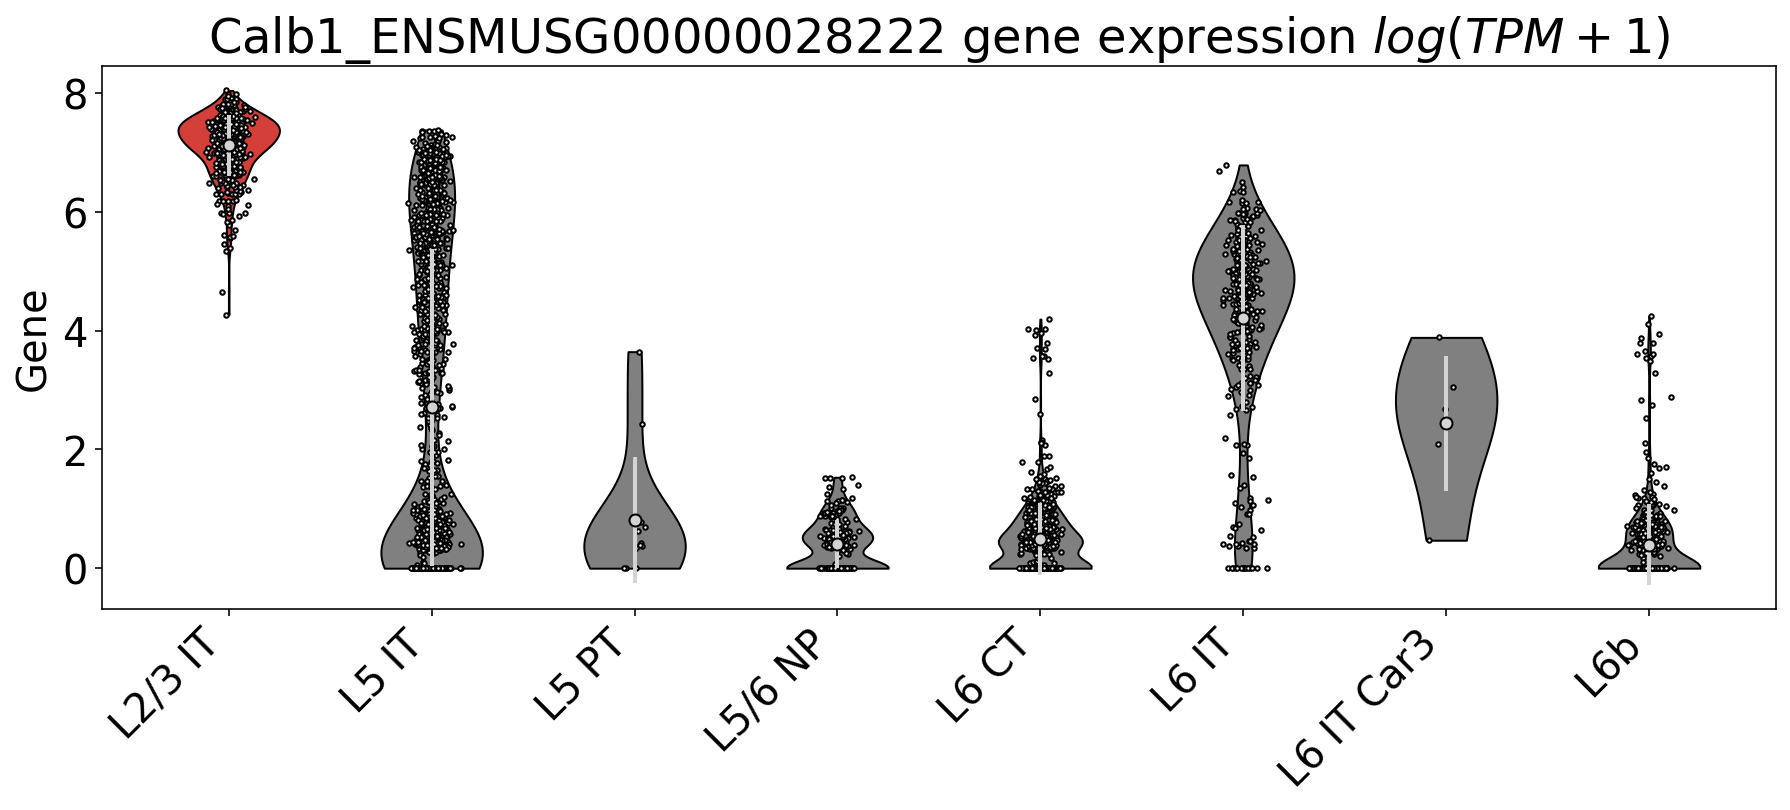

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]


#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax,selected=midx, xticks=lidx, xticklabels=labels)

ax.set(**{
    "ylabel": "Gene",
    "title": "{} gene expression $log(TPM + 1)$".format(specific_gene)
})

#plt.savefig("./plots/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [16]:
identified_genes = markers_gene["name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [17]:
print("{} genes identified.".format(identified_genes.nunique()))

9397 genes identified.


In [18]:
markers_gene.to_csv("./tables/bad_gene_subclass_DE-GLUT.csv")